In [1]:
from DeepScence.api import DeepScence
import scanpy as sc
from dca.api import dca
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

2025-04-07 18:48:09.117638: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-07 18:48:09.117686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/hpc/home/yq96/AnthonyQ/.conda/envs/sene/lib/python3.8/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


### Input
DeepScence take as input a properly filtered, ideally denoised expression matrix in the form of `AnnData` object. If start with raw count matrix, we recommend performing denoise using `DCA` or other methods first.

In [2]:
# construct adata
counts = pd.read_csv('./origin_matrix_GSE94980.txt', sep = '\t').T
adata = sc.AnnData(counts)
adata.obs['condition'] = [x.split('_')[-1]=='OSKM' for x in adata.obs_names]
adata.obs["SnC"] = (adata.obs["condition"]).astype(int)
adata.X = adata.X.astype(np.float32)

# denoise
sc.pp.filter_genes(adata, min_cells=1)
dca(adata)

dca: Successfully preprocessed 16871 genes and 200 cells.


2025-04-07 18:48:17.189440: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-04-07 18:48:17.189857: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-07 18:48:17.189868: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-07 18:48:17.189893: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dcc-biostat-20): /proc/driver/nvidia/version does not exist


2025-04-07 18:48:17,495 [WARNING] From /hpc/home/yq96/AnthonyQ/.conda/envs/sene/lib/python3.8/site-packages/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

2025-04-07 18:48:17.499746: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 18:48:17.500056: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-04-07 18:48:17.848043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2025-04-07 18:48:17.859253: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799995000 

dca: Calculating reconstructions...


### Running DeepScence
DeepScence is a convenient one-line wrapper function that execute all workflow. The output of DeepScence is an updated `AnnData` object with 2 additional columns appended to `adata.obs`:
1. `adata.obs["ds"]` is the DeepScence score for each cell.
2. `adata.obs["binary"]` is the binarized SnC label if user specify `binarize=True`.

DeepScence automatically detect if GPU is available in your environment, and is compatible with GPU to speed up calculations.

[2025-04-07 18:48] GPU not available, using CPU...
[2025-04-07 18:48] Input is not count, processed 16871 genes and 200 cells.
[2025-04-07 18:48] Using 35 genes in the gene set for scoring.
[2025-04-07 18:48] Lambda provided, capturing scores in 2 neurons.
[2025-04-07 18:48] Training on 180 cells, validate on 20 cells.
100%|██████████| 300/300 [00:01<00:00, 251.87it/s]


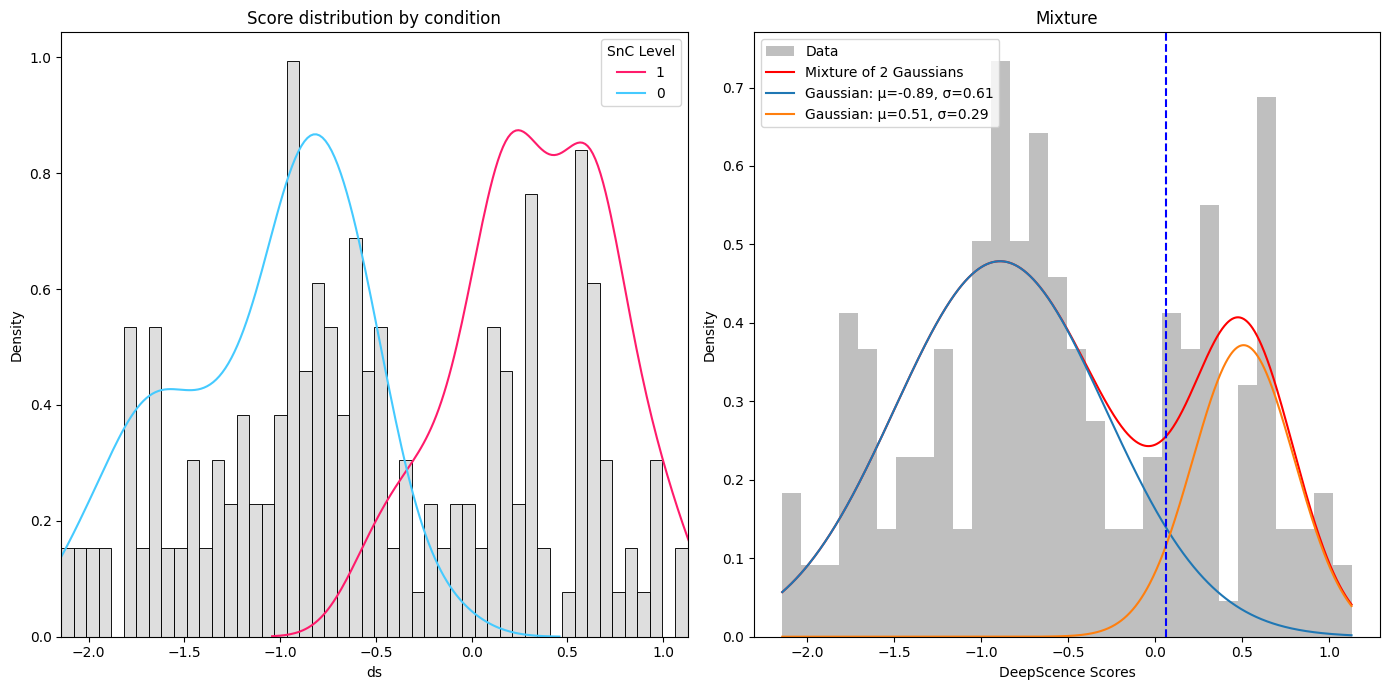

In [3]:
adata = DeepScence(adata, binarize=True)

### Visualization
Normally you wouldn't have SnC labels in `adata.obs['SnC']`, this is one of the in-vitro validation datasets used in the manuscript, we compare the predicted results vs. the true labels.

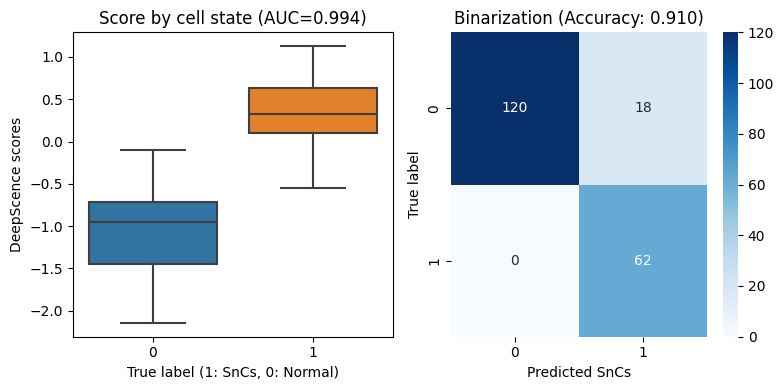

In [4]:
binary_numeric = adata.obs["binary"].map({"SnC": 1, "Normal": 0}).values
auroc = roc_auc_score(adata.obs["SnC"].values, adata.obs["ds"].values)
accuracy = accuracy_score(binary_numeric, adata.obs["SnC"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(x=adata.obs["SnC"], y=adata.obs["ds"], ax=ax1)
ax1.set_title(f"Score by cell state (AUC={auroc:.3f})")
ax1.set_xlabel("True label (1: SnCs, 0: Normal)")
ax1.set_ylabel("DeepScence scores")

cm = confusion_matrix(binary_numeric, adata.obs["SnC"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f"Binarization (Accuracy: {accuracy:.3f})")
ax2.set_xlabel("Predicted SnCs")
ax2.set_ylabel("True label")

plt.tight_layout()
plt.show()

### Running DeepScence on mouse data, or with self-defined genesets
1. If dealing with mouse dataset, specify `species="mouse"` in the function.
2. To use a costomize gene set for scoring, prepare the gene list as a `list[str]` and set to `custome_gs`. See examples below:

In [ ]:
# running mouse dataset
adata = DeepScence(adata, binarize=True, species="mouse")

# running with customized gene set
gs = ["CDKN1A", "CDKN2A", "IL6", "CDKN2B"]
adata = DeepScence(adata, binarize=True, custome_gs=gs)